In [1]:
#imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.io as pio

from helpers.datasetHelper import get_samples, split_data
from imblearn.over_sampling import SMOTE
from sklearn.metrics import cohen_kappa_score

from helpers.ploting import display_confusion_matrix_pink_variants
from helpers.metaheuristics import run_pso_with_progress, run_ga_with_progress
from models import MyXGboost
import numpy as np
from sklearn.metrics import recall_score, precision_score

# Update the import to match the actual function name in hiper_params_search.py
from hiper_params_search import get_best_xgboost

# Set the default renderer to 'browser' to ensure plots open in the browser
pio.renderers.default = 'browser'

In [2]:
directory_path_combined = './datasets/GEO'
GSE32396_HEALTHY_BRCA = get_samples(os.path.join(directory_path_combined, 'GSE32396-HEALTHYxBRCA.csv'))
GSE41037_HEALTHY = get_samples(os.path.join(directory_path_combined, 'GSE41037_HEALTHY.csv'))
GSE57285_HEALTHY_BRCA = get_samples(os.path.join(directory_path_combined, 'GSE57285-HEALTHYxBRCA.csv'))
GSE58045_HEALTHY_UNK = get_samples(os.path.join(directory_path_combined, 'GSE58045-HEALTHY-UNK.csv'))
GSE32396_HEALTHY_BRCA = get_samples(os.path.join(directory_path_combined, 'GSE32396-HEALTHYxBRCA.csv'))
GSE58119_HEALTHY_PREBRCA = get_samples(os.path.join(directory_path_combined, 'GSE58119-HEALTHYxPRE-BRCA.csv'))

datasets_list = [
    GSE32396_HEALTHY_BRCA,
    GSE41037_HEALTHY,
    GSE57285_HEALTHY_BRCA,
    GSE58045_HEALTHY_UNK,
    GSE58119_HEALTHY_PREBRCA
]

tag_counts = {}
all_instances = []

for idx, dataset in enumerate(datasets_list):
    # Ignore the first column for all rows except the header
    tags = [row[1:] if i == 0 else row[-1] for i, row in enumerate(dataset)]
    # For header row, skip (do not count as tag)
    tags = [tag for tag in tags if not isinstance(tag, (np.ndarray, list))]
    unique_tags, counts = np.unique(tags, return_counts=True)
    print(f"Dataset {idx+1}:")
    for tag, count in zip(unique_tags, counts):
        print(f"  {tag}: {count}")
        tag_counts[tag] = tag_counts.get(tag, 0) + count
    print(f"  Total: {len(tags)}")
    # Add all rows except header, and ignore first column
    all_instances.extend([row[1:] for row in dataset[1:]])

print("\nConcatenated dataset:")
all_tags = [row[-1] for row in all_instances]
unique_tags_all, counts_all = np.unique(all_tags, return_counts=True)
for tag, count in zip(unique_tags_all, counts_all):
    print(f"  {tag}: {count}")
print(f"  Total: {len(all_tags)}")

/Users/leandro/UPE/master/Mamo.IA/helpers/datasetHelper.py:6: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/leandro/UPE/master/Mamo.IA/helpers/datasetHelper.py:6: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,1

Dataset 1:
  BRCA-MT: 15
  BRCA-WT: 15
  HEALTHY-MT: 15
  HEALTHY-WT: 15
  Total: 60
Dataset 2:
  HEALTHY-UNK: 394
  NOT_INTERESTED: 326
  Total: 720
Dataset 3:
  BRCA-MT: 35
  HEALTHY-MT: 7
  HEALTHY-WT: 42
  Total: 84
Dataset 4:
  HEALTHY-UNK: 172
  Total: 172
Dataset 5:
  HEALTHY-UNK: 148
  PRE-BRCA: 134
  Total: 282

Concatenated dataset:
  BRCA-MT: 50
  BRCA-WT: 15
  HEALTHY-MT: 22
  HEALTHY-UNK: 714
  HEALTHY-WT: 57
  NOT_INTERESTED: 326
  PRE-BRCA: 134
  Total: 1318


/Users/leandro/UPE/master/Mamo.IA/helpers/datasetHelper.py:6: DtypeWarning:

Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,25

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_all_instances_interpretable(all_instances):
    """
    Normalize all instances using MinMax scaling (0-1 range)
    Preserves interpretability and relationships
    """
    # Convert to DataFrame if it's not already
    if not isinstance(all_instances, pd.DataFrame):
        all_instances_df = pd.DataFrame(all_instances)
    else:
        all_instances_df = all_instances.copy()
    
    # Apply MinMax scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    all_instances_normalized = pd.DataFrame(
        scaler.fit_transform(all_instances_df),
        columns=all_instances_df.columns,
        index=all_instances_df.index
    )
    
    # Print normalization summary
    print("✅ Normalization Complete - MinMax Scaling (0-1 range)")
    print(f"📊 Original shape: {all_instances_df.shape}")
    print(f"🎯 Normalized shape: {all_instances_normalized.shape}")
    print(f"📈 Value range: [{all_instances_normalized.min().min():.4f}, {all_instances_normalized.max().max():.4f}]")
    
    # Show before/after comparison for a few features
    print("\n🔍 Before/After Comparison (first 5 features):")
    comparison = pd.DataFrame({
        'Original_Min': all_instances_df.iloc[:, :5].min(),
        'Original_Max': all_instances_df.iloc[:, :5].max(),
        'Normalized_Min': all_instances_normalized.iloc[:, :5].min(),
        'Normalized_Max': all_instances_normalized.iloc[:, :5].max()
    })
    print(comparison.round(4))
    
    return {
        'normalized_data': all_instances_normalized,
        'scaler': scaler,
        'original_data': all_instances_df
    }

healthy_mt_cases, healthy_wt_cases, healthy_unk_cases, prebrca_cases, brca_mt_cases, brca_wt_cases = split_data(all_instances)

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, recall_score, f1_score, precision_score
import numpy as np

def evaluate_model_detailed(model_name, model, X, y_true, label_encoder):
    """
    Comprehensive model evaluation with all requested metrics
    """
    # Get predictions
    y_pred = model.predict(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, average='binary')  # Same as recall
    precision = precision_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    # Print results
    print(f"\n=== {model_name} Set Evaluation ===")
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Kappa:       {kappa:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    
    # Print class labels for reference
    print(f"Class labels: {label_encoder.classes_}")
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'sensitivity': sensitivity,
        'precision': precision,
        'f1_score': f1,
    }


# Alternative simpler version if you prefer less verbose output:
def evaluate_model_multiclass_simple(model_name, model, X, y_true, label_encoder):
    """
    Simplified multiclass evaluation with key metrics
    """
    y_pred = model.predict(X)
    
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n=== {model_name} Set - Multiclass ===")
    print(f"Accuracy:           {accuracy:.4f}")
    print(f"Cohen's Kappa:      {kappa:.4f}")
    print(f"Macro F1-Score:     {f1_macro:.4f}")
    print(f"Weighted F1-Score:  {f1_weighted:.4f}")
    
    # Per-class F1 scores
    f1_per_class = f1_score(y_true, y_pred, average=None)
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"F1-Score {class_name}: {f1_per_class[i]:.4f}")
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class
    }

In [5]:
def process_dataframes(X, Y):
    n_features = X.shape[1]
    print(f"Loaded dataset with {n_features} features and {len(Y)} samples")

    # Use DecisionTreeClassifier as the estimator
    estimator = MyXGboost.DecisionTreeMultiClass()

    # Run PSO
    best_weights, best_fitness, progress, X_selected = run_pso_with_progress(
        X, Y, estimator, n_features,
        swarmsize=30,
        maxiter=10,
        threshold=0.7
    )

    X_selected_pso = X.iloc[:, X_selected]

    best_weights_ga, best_fitness_ga, progress_ga, X_selected_proc = run_ga_with_progress(
    X, Y, estimator, X.shape[1], 
    pop_size=25, n_generations=10, threshold=0.8
    )

    X_selected_ga = X.iloc[:, X_selected_proc]

    # Use LabelEncoder to encode the target classes
    label_encoder = LabelEncoder()
    label_encoder.fit(Y)
    Y_encoded = label_encoder.transform(Y)
    print("Label indices and names:")
    for idx, name in enumerate(label_encoder.classes_):
        print(f"{idx}: {name}")

    print(f"Encoded target classes: {label_encoder.classes_}")

    # 1) evaluate with all features
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X, Y_encoded, test_size=0.3, random_state=42
    )    
    # Split X_test_all and y_test_all into validation and test sets (15% each)
    X_val_nfs, X_test_nfs, y_val_nfs, y_test_nfs = train_test_split(
        X_test_all, y_test_all, test_size=0.5, random_state=42
    )

    # 2) evaluate with selected features
    X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(
        X_selected_ga, Y_encoded, test_size=0.3, random_state=42
    )
    # Split X_test_all and y_test_all into validation and test sets (15% each)
    X_val_ga, X_test_ga, y_val_ga, y_test_ga = train_test_split(
        X_test_ga, y_test_ga, test_size=0.5, random_state=42
    )

    # 3) evaluate with PSO selected features
    X_train_pso, X_test_pso, y_train_pso, y_test_pso = train_test_split(
        X_selected_pso, Y_encoded, test_size=0.3, random_state=42
    )
    # Split X_test_all and y_test_all into validation and test sets (15% each)
    X_val_pso, X_test_pso, y_val_pso, y_test_pso = train_test_split(
        X_test_pso, y_test_pso, test_size=0.5, random_state=42
    )

    # Apply SMOTE to balance the training instances - ALL
    smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
    X_train_nfs, y_train_nfs = smote.fit_resample(X_train_nfs, y_train_nfs)

    # Apply SMOTE to balance the training instances - GA
    smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
    X_train_ga, y_train_ga = smote.fit_resample(X_train_ga, y_train_ga)

    # Apply SMOTE to balance the training instances - PSO
    smote = SMOTE(sampling_strategy='auto', random_state=None, k_neighbors=10)
    X_train_pso, y_train_pso = smote.fit_resample(X_train_pso, y_train_pso)

    return [('GA', X_train_ga, X_test_ga, X_val_ga, y_train_ga, y_test_ga, y_val_ga), 
                   ('PSO', X_train_pso, X_test_pso, X_val_pso, y_train_pso, y_test_pso, y_val_pso),
                   ('ALL', X_train_nfs, X_test_nfs, X_val_nfs, y_train_nfs, y_test_nfs, y_val_nfs)]

In [6]:
healthy_mt_cases = pd.DataFrame(healthy_mt_cases)
healthy_wt_cases = pd.DataFrame(healthy_wt_cases)
healthy_unk_cases = pd.DataFrame(healthy_unk_cases)

prebrca_cases = pd.DataFrame(prebrca_cases)

brca_mt_cases = pd.DataFrame(brca_mt_cases)
brca_wt_cases = pd.DataFrame(brca_wt_cases)

healthy_consolidated_cases = pd.concat([healthy_mt_cases, healthy_wt_cases], ignore_index=True)
healthy_consolidated_cases['Tag'] = 'HEALTHY'
brca_consolidated_cases = pd.concat([brca_mt_cases, brca_wt_cases], ignore_index=True)
brca_consolidated_cases['Tag'] = 'BRCA'

healthy_mt_cases['Tag'] = 'HEALTHY-MT'
healthy_wt_cases['Tag'] = 'HEALTHY-WT'
healthy_unk_cases['Tag'] = 'HEALTHY-UNK'

prebrca_cases['Tag'] = 'PRE-BRCA'

brca_mt_cases['Tag'] = 'BRCA-MUT'
brca_wt_cases['Tag'] = 'BRCA-WT'

brca_consolidated_cases['Tag'] = 'BRCA'

print(f"Healthy MT cases shape: {healthy_mt_cases.shape}")
print(f"Healthy WT cases shape: {healthy_wt_cases.shape}")
print(f"Healthy consolidated cases shape: {healthy_consolidated_cases.shape}")
print("--------------------------------------------------")
print(f"PRE-BRCA cases shape: {prebrca_cases.shape}")
print("--------------------------------------------------")
print(f"BRCA MT cases shape: {brca_mt_cases.shape}")
print(f"BRCA WT cases shape: {brca_wt_cases.shape}")    
print(f"BRCA consolidated cases shape: {brca_consolidated_cases.shape}")

Healthy MT cases shape: (22, 27578)
Healthy WT cases shape: (57, 27578)
Healthy consolidated cases shape: (79, 27578)
--------------------------------------------------
PRE-BRCA cases shape: (134, 27578)
--------------------------------------------------
BRCA MT cases shape: (50, 27578)
BRCA WT cases shape: (15, 27578)
BRCA consolidated cases shape: (65, 27578)


In [7]:
from typing import Counter


df_cancer = pd.concat([healthy_unk_cases[400:500],  healthy_consolidated_cases, prebrca_cases, brca_consolidated_cases], ignore_index=True) #blood samples
X = df_cancer.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
# X = normalize_all_instances_interpretable(X)['normalized_data']
Y = df_cancer.iloc[:, -1]

# Fill missing values with the lowest value of its cpg site
label_encoder = LabelEncoder()
label_encoder.fit(Y)
Y_encoded = label_encoder.transform(Y)

print("Label indices and names:")
for idx, name in enumerate(label_encoder.classes_):
    print(f"{idx}: {name}")

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, Y_encoded, test_size=0.40, random_state=42
)

# Split X_test_all and y_test_all into validation and test sets (15% each)
X_val_nfs, X_test_nfs, y_val_nfs, y_test_nfs = train_test_split(
    X_test_all, y_test_all, test_size=0.5, random_state=42
)

train_mins = X_train_all.mean()

# Apply to all sets
X_train_nfs = X_train_all.fillna(train_mins)
X_val_nfs = X_val_nfs.fillna(train_mins)
X_test_nfs = X_test_nfs.fillna(train_mins)

print("Class distribution in full dataset:")
print(pd.Series(Y_encoded).value_counts().sort_index())

print("Class distribution in training set (nfs):")
print(pd.Series(y_train_all).value_counts().sort_index())

print("Class distribution in test set:")
print(pd.Series(y_test_nfs).value_counts().sort_index())

print("Class distribution in validation set:")
print(pd.Series(y_val_nfs).value_counts().sort_index())

# Generate exactly 10 samples for the minority class
class_counts = Counter(Y_encoded)
min_class = min(class_counts, key=class_counts.get)

smote = SMOTE(sampling_strategy={min_class: 80}, random_state=42, k_neighbors=20)
X_train_nfs, y_train_all = smote.fit_resample(X_train_nfs, y_train_all)

selector = MyXGboost.XGBoostMultiClass()[0].fit(X_train_nfs, y_train_all)
# Evaluate the model on the validation set
evaluate_model_multiclass_simple("Validation", selector, X_val_nfs, y_val_nfs, label_encoder)
evaluate_model_multiclass_simple("Test", selector, X_test_nfs, y_test_nfs, label_encoder)

Label indices and names:
0: BRCA
1: HEALTHY
2: HEALTHY-UNK
3: PRE-BRCA
Class distribution in full dataset:
0     65
1     79
2    100
3    134
Name: count, dtype: int64
Class distribution in training set (nfs):
0    37
1    45
2    56
3    88
Name: count, dtype: int64
Class distribution in test set:
0    12
1    15
2    22
3    27
Name: count, dtype: int64
Class distribution in validation set:
0    16
1    19
2    22
3    19
Name: count, dtype: int64


/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.




=== Validation Set - Multiclass ===
Accuracy:           0.8158
Cohen's Kappa:      0.7537
Macro F1-Score:     0.7963
Weighted F1-Score:  0.8103
F1-Score BRCA: 0.6471
F1-Score HEALTHY: 0.5882
F1-Score HEALTHY-UNK: 1.0000
F1-Score PRE-BRCA: 0.9500

=== Test Set - Multiclass ===
Accuracy:           0.8684
Cohen's Kappa:      0.8174
Macro F1-Score:     0.8024
Weighted F1-Score:  0.8588
F1-Score BRCA: 0.5000
F1-Score HEALTHY: 0.7500
F1-Score HEALTHY-UNK: 0.9778
F1-Score PRE-BRCA: 0.9818


{'accuracy': 0.868421052631579,
 'kappa': np.float64(0.81743934662503),
 'f1_macro': 0.80239898989899,
 'f1_weighted': 0.8588184476342371,
 'f1_per_class': array([0.5       , 0.75      , 0.97777778, 0.98181818])}

In [8]:
test = prebrca_cases.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
probabilities = selector.predict_proba(test)
# Get class names
print("Label indices and names:")
for idx, name in enumerate(label_encoder.classes_):
    print(f"{idx}: {name}")

class_names = selector.classes_
print("\n📈 SUMMARY STATISTICS:")
print("=" * 40)

# Average probabilities per class
avg_probs = probabilities.mean(axis=0)
print("Average probabilities per class:")
for class_name, avg_prob in zip(class_names, avg_probs):
    print(f"  {class_name}: {avg_prob:.4f}")

# Most confident predictions
max_confidences = probabilities.max(axis=1)
print(f"\nConfidence statistics:")
print(f"  Average confidence: {max_confidences.mean():.4f}")
print(f"  Min confidence: {max_confidences.min():.4f}")
print(f"  Max confidence: {max_confidences.max():.4f}")

Label indices and names:
0: BRCA
1: HEALTHY
2: HEALTHY-UNK
3: PRE-BRCA

📈 SUMMARY STATISTICS:
Average probabilities per class:
  0: 0.0032
  1: 0.0026
  2: 0.0063
  3: 0.9879

Confidence statistics:
  Average confidence: 0.9917
  Min confidence: 0.5488
  Max confidence: 0.9973


/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

divide by zero encountered in matmul

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

overflow encountered in matmul

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning:

invalid value encountered in matmul

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

divide by zero encountered in matmul

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

overflow encountered in matmul

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning:

invalid value encountered in matmul

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/

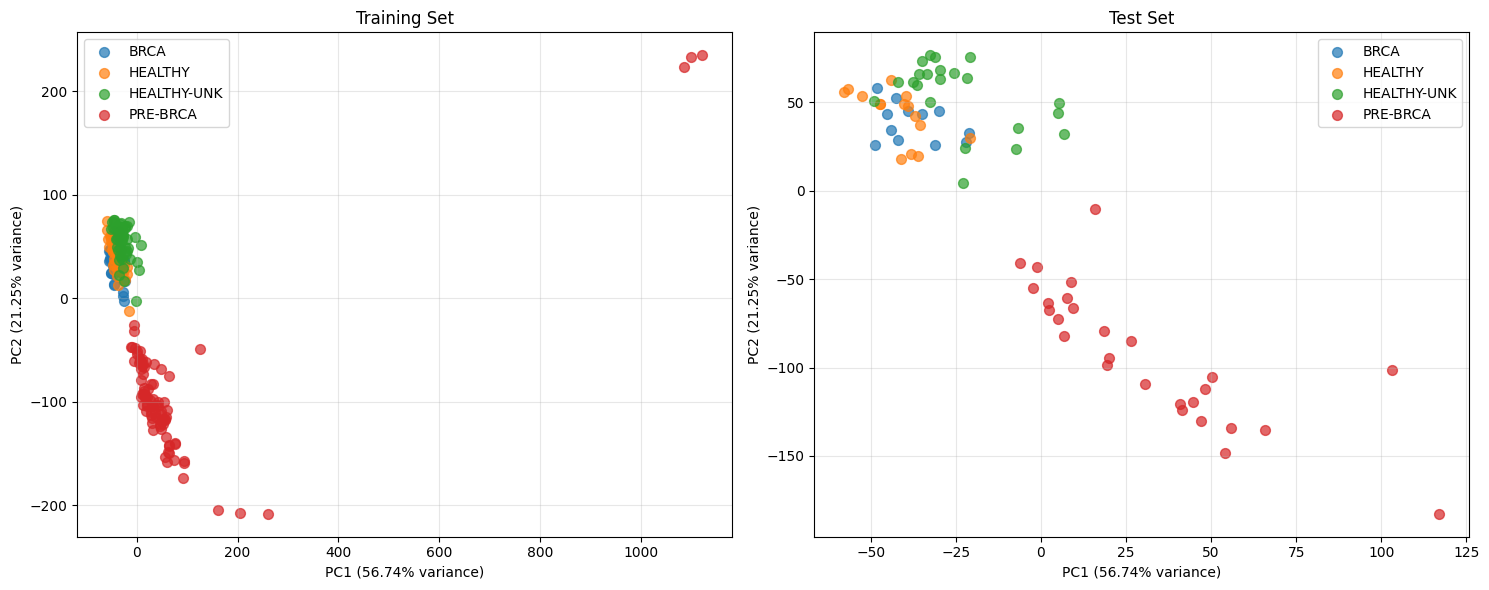

Total explained variance: 0.7799


((array([[-3.88127341e+01,  3.81076405e+01],
         [-5.07021229e+01,  5.91514201e+01],
         [ 4.62703360e+01, -1.21246660e+02],
         [-4.54825326e+01,  7.35228835e+01],
         [-1.42640504e+01,  7.30264596e+01],
         [-2.64296365e+01,  2.41516053e+01],
         [-4.29498607e+01,  6.62399282e+01],
         [-3.16889160e+01,  2.66430731e+01],
         [ 8.89357017e+00, -6.85184969e+01],
         [-5.04597946e+01,  6.64390897e+01],
         [ 1.08074846e+01, -5.88274580e+01],
         [-2.27088036e+01,  6.94237954e+01],
         [-3.07604488e+01,  5.41010868e+01],
         [-3.93055995e+01,  5.70375737e+01],
         [-4.80337280e+01,  5.27723824e+01],
         [-1.61001421e+01, -1.28598117e+01],
         [-2.38353192e+01,  6.78389757e+01],
         [-2.84933989e+01,  2.44438582e+01],
         [ 4.03554235e-01, -5.45282197e+01],
         [ 5.28011797e+01, -1.17148594e+02],
         [ 3.30827227e+01, -1.04337872e+02],
         [-2.31959551e-01, -5.10242000e+01],
         [

In [ ]:
# Version to compare training vs test distributions
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler


def plot_pca_comparison(X_train, y_train, X_test, y_test, label_encoder, 
                       titles=("Training Set", "Test Set"), figsize=(15, 6)):
    """
    Compare PCA distributions between training and test sets
    """
    
    # Standardize using training statistics
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA fitted on training data
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot training set
    for class_idx, class_name in enumerate(label_encoder.classes_):
        mask_train = (y_train == class_idx)
        ax1.scatter(X_train_pca[mask_train, 0], X_train_pca[mask_train, 1], 
                   label=class_name, alpha=0.7, s=50)
    
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title(titles[0])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot test set
    for class_idx, class_name in enumerate(label_encoder.classes_):
        mask_test = (y_test == class_idx)
        ax2.scatter(X_test_pca[mask_test, 0], X_test_pca[mask_test, 1], 
                   label=class_name, alpha=0.7, s=50)
    
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.set_title(titles[1])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return (X_train_pca, X_test_pca), pca

plot_pca_comparison(X_train_nfs, y_train_all, X_test_nfs, y_test_nfs, label_encoder,
                   titles=("Training Set", "Test Set"), figsize=(15, 6))

In [10]:
models_multiclass = [
    {
        'Name': 'Random Forest',
        'Model': MyXGboost.RandomForest300()
    },
    {
        'Name': 'XGBoost',
        'Model': MyXGboost.XGBoostMultiClass()
    },
    {
        'Name': 'Light GBM',
        'Model': MyXGboost.LightGBMMulticlass()
    },
    {
        'Name': 'Gradient Boosting',
        'Model': MyXGboost.GradientBoosting()
    },
    {
        'Name': 'Ada Boost',
        'Model': MyXGboost.AdaBoostMultiClass()
    }
]

In [11]:
def process_pso(df_cancer):
    X = df_cancer.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
    Y = df_cancer.iloc[:, -1]

    # Fill missing values with the lowest value of its cpg site
    X = X.apply(lambda col: col.fillna(col.min()), axis=0)

    n_features = X.shape[1]
    print(f"Loaded dataset with {n_features} features and {len(Y)} samples")

    # Use DecisionTreeClassifier as the estimator
    estimator = MyXGboost.DecisionTreeMultiClass()

    # Run PSO
    best_weights, best_fitness, progress, X_selected = run_pso_with_progress(
        X, Y, estimator, n_features,
        swarmsize=30,
        maxiter=10,
        threshold=0.8
    )


    X_selected_pso = X.iloc[:, X_selected]

    print(f"Done PSO → best fitness = {best_fitness:.4f}")

    return X_selected_pso

def process_ga(df_cancer):
    X = df_cancer.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
    Y = df_cancer.iloc[:, -1]

    # Fill missing values with the lowest value of its cpg site
    X = X.apply(lambda col: col.fillna(col.min()), axis=0)

    n_features = X.shape[1]
    print(f"Loaded dataset with {n_features} features and {len(Y)} samples")

    # Use DecisionTreeClassifier as the estimator
    estimator = MyXGboost.DecisionTreeMultiClass()

    best_weights_ga, best_fitness_ga, progress_ga, X_selected_proc = run_ga_with_progress(
        X, Y, estimator, X.shape[1], 
        pop_size=30, n_generations=5, threshold=0.8
    )


    X_selected_ga = X.iloc[:, X_selected_proc]

    return X_selected_ga

datasets = {
    'Healthy vs PRE-BRCA VS BRCA': [healthy_unk_cases, prebrca_cases, brca_consolidated_cases]
}

In [12]:
selectors_pso = []

dataset = pd.concat([healthy_unk_cases[400:500],  healthy_consolidated_cases, prebrca_cases, brca_consolidated_cases], ignore_index=True)
X_selected_pso = process_pso(dataset)
Y_pso = dataset.iloc[:, -1]

X_selected_ga = process_ga(dataset)
Y_ga = dataset.iloc[:, -1]

Y_encoded_pso = label_encoder.fit_transform(Y_pso)
Y_encoded_ga = label_encoder.fit_transform(Y_ga)

print(f"Total features selected by GA: {X_selected_ga.shape}")
print(f"Total features selected by PSO: {X_selected_pso.shape}")

Loaded dataset with 27577 features and 378 samples
Eval 10: best fitness so far = 0.3073
Eval 20: best fitness so far = 0.2823
Eval 30: best fitness so far = 0.2823
Eval 40: best fitness so far = 0.2823
Eval 50: best fitness so far = 0.2670
Eval 60: best fitness so far = 0.2670
Eval 70: best fitness so far = 0.2670
Eval 80: best fitness so far = 0.2670
Eval 90: best fitness so far = 0.2670
Eval 100: best fitness so far = 0.2670
Eval 110: best fitness so far = 0.2670
Eval 120: best fitness so far = 0.2670
Eval 130: best fitness so far = 0.2670
Eval 140: best fitness so far = 0.2670
Eval 150: best fitness so far = 0.2670
Eval 160: best fitness so far = 0.2670
Eval 170: best fitness so far = 0.2670
Eval 180: best fitness so far = 0.2670
Eval 190: best fitness so far = 0.2670
Eval 200: best fitness so far = 0.2670
Eval 210: best fitness so far = 0.2670
Eval 220: best fitness so far = 0.2670
Eval 230: best fitness so far = 0.2670
Eval 240: best fitness so far = 0.2670
Eval 250: best fitness

In [18]:
import time
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

def apply_feature_selection(X_train, X_test, feature_indices):    
    X_train_selected = X_train.iloc[:, feature_indices] if isinstance(X_train, pd.DataFrame) else X_train[:, feature_indices]
    X_test_selected = X_test.iloc[:, feature_indices] if isinstance(X_test, pd.DataFrame) else X_test[:, feature_indices]
    
    print(f"Original shape: {X_train.shape} -> Selected shape: {X_train_selected.shape}")
    return X_train_selected, X_test_selected

def test_models_with_features(X_train, X_test, y_train, y_test, feature_sets):
    
    results = []
    
    for feature_set_name, feature_indices in feature_sets.items():
        print(f"\n{'='*60}")
        print(f"TESTING FEATURE SET: {feature_set_name}")
        print(f"Number of features: {len(feature_indices)}")
        print(f"{'='*60}")
        
        # Apply feature selection
        X_train_sel, X_test_sel = apply_feature_selection(X_train, X_test, feature_indices)
        
        for m in models_multiclass:
            print(f"\n📊 {m['Name']}...")
            model = m['Model'][0]
            model_name = m['Name']
            
            try:
                start_time = time.time()
                
                # Train model
                model.fit(X_train_sel, y_train)
                
                # Predictions
                y_pred = model.predict(X_test_sel)
                #y_pred_proba = model.predict_proba(X_test_sel)[:, 1] if hasattr(model, 'predict_proba') else None
    
                accuracy = accuracy_score(y_test, y_pred)
                kappa = cohen_kappa_score(y_test, y_pred)
                kappa_scorer = make_scorer(cohen_kappa_score)
                f1_macro = f1_score(y_test, y_pred, average='macro')
                f1_weighted = f1_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted')
                precision = precision_score(y_test, y_pred, average='weighted')
                
                print(f"\n=== {model_name} Set - Multiclass ===")
                print(f"Accuracy:           {accuracy:.4f}")
                print(f"Cohen's Kappa:      {kappa:.4f}")
                print(f"Macro F1-Score:     {f1_macro:.4f}")
                print(f"Weighted F1-Score:  {f1_weighted:.4f}")
                print(f"Recall:             {recall:.4f}")
                print(f"Precision:          {precision:.4f}")
                
                # Per-class F1 scores
                f1_per_class = f1_score(y_test, y_pred, average=None)
                for i, class_name in enumerate(label_encoder.classes_):
                    print(f"F1-Score {class_name}: {f1_per_class[i]:.4f}")

                training_time = time.time() - start_time
                
                # Cross-validation score
                cv_scores = cross_val_score(model, X_train_sel, y_train, cv=5, scoring=kappa_scorer)
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
                
                # Store results
                result = {
                    'feature_set': feature_set_name,
                    'model': model_name,
                    'num_features': len(feature_indices),
                    'accuracy': accuracy,
                    'Kappa': kappa,
                    'f1_macro': f1_macro,
                    'f1_score': f1_weighted,
                    'precision': precision,
                    'recall': recall,
                    'cv_mean': cv_mean,
                    'cv_std': cv_std,
                    'training_time': training_time,
                    'feature_indices': feature_indices
                }
                
                results.append(result)
                
                print(f"   ✅  Accuracy: {accuracy:.4f}, Kappa: {kappa:.4f}, F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
                print(f"   ⏱️  Time: {training_time:.2f}s")
                
            except Exception as e:
                print(f"   ❌ Error with {model_name}: {str(e)}")
                continue
    
    return pd.DataFrame(results)

def analyze_results(results_df):
    """
    Analyze and visualize the results
    """
    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    
    # Display best results per feature set
    best_per_feature_set = results_df.loc[results_df.groupby('feature_set')['accuracy'].idxmax()]
    print("\n🏆 BEST MODEL PER FEATURE SET:")
    print(best_per_feature_set[['feature_set', 'model', 'accuracy', 'f1_score', 'num_features']].round(4))
    
    # Display overall best
    overall_best = results_df.loc[results_df['accuracy'].idxmax()]
    print(f"\n🎯 OVERALL BEST MODEL:")
    print(f"   Model: {overall_best['model']}")
    print(f"   Feature Set: {overall_best['feature_set']}")
    print(f"   Accuracy: {overall_best['accuracy']:.4f}")
    print(f"   F1-Score: {overall_best['f1_score']:.4f}")
    print(f"   Features: {overall_best['num_features']}")
    
    return best_per_feature_set, overall_best

def plot_comparison(results_df):
    """
    Create comparison plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Accuracy by model and feature set
    pivot_acc = results_df.pivot_table(index='model', columns='feature_set', values='accuracy')
    sns.heatmap(pivot_acc, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Accuracy by Model and Feature Set')
    
    # Plot 2: Number of features vs accuracy
    sns.scatterplot(data=results_df, x='num_features', y='accuracy', hue='model', 
                   style='feature_set', s=100, ax=axes[0,1])
    axes[0,1].set_title('Number of Features vs Accuracy')
    
    # Plot 3: Model performance comparison
    results_melted = results_df.melt(id_vars=['model', 'feature_set'], 
                                    value_vars=['accuracy', 'f1_score', 'precision', 'recall'],
                                    var_name='metric', value_name='score')
    sns.boxplot(data=results_melted, x='model', y='score', hue='metric', ax=axes[1,0])
    axes[1,0].set_title('Model Performance Distribution')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Training time comparison
    sns.barplot(data=results_df, x='model', y='training_time', hue='feature_set', ax=axes[1,1])
    axes[1,1].set_title('Training Time by Model and Feature Set')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def run_comprehensive_feature_testing(X_train, X_test, y_train, y_test, pso_features, ga_features, all_features=None):
    """
    Complete testing pipeline for PSO and GA feature sets
    """
    # Define feature sets to test
    feature_sets = {
        'PSO_Features': pso_features,
        'GA_Features': ga_features,
        'All_Features': list(range(X_train.shape[1]))  # Benchmark with all features
    }
    
    print("🚀 STARTING COMPREHENSIVE FEATURE SET TESTING")
    print(f"PSO Features: {len(pso_features)} features")
    print(f"GA Features: {len(ga_features)} features")
    print(f"All Features: {X_train.shape[1]} features")
    
    # Test all models with all feature sets
    results_df = test_models_with_features(X_train, X_test, y_train, y_test, feature_sets)
    
    # Analyze results
    best_per_set, overall_best = analyze_results(results_df)
    
    # Create visualizations
    plot_comparison(results_df)
    
    # Detailed comparison
    print("\n📋 DETAILED RESULTS:")
    print(results_df.round(4))
    
    return results_df, best_per_set, overall_best

def get_best_feature_set_per_model(results_df):
    """
    Get the best feature set for each model
    """
    best_per_model = results_df.loc[results_df.groupby('model')['accuracy'].idxmax()]
    return best_per_model[['model', 'feature_set', 'accuracy', 'num_features']]

🚀 STARTING COMPREHENSIVE FEATURE SET TESTING
PSO Features: 6178 features
GA Features: 5577 features
All Features: 27577 features

TESTING FEATURE SET: PSO_Features
Number of features: 6178
Original shape: (269, 27577) -> Selected shape: (269, 6178)

📊 Random Forest...

=== Random Forest Set - Multiclass ===
Accuracy:           0.8553
Cohen's Kappa:      0.8008
Macro F1-Score:     0.7964
Weighted F1-Score:  0.8533
Recall:             0.8553
Precision:          0.8599
F1-Score BRCA: 0.5926
F1-Score HEALTHY: 0.6154
F1-Score HEALTHY-UNK: 0.9778
F1-Score PRE-BRCA: 1.0000
   ✅  Accuracy: 0.8553, Kappa: 0.8008, F1 Macro: 0.7964, F1 Weighted: 0.8533, Precision: 0.8599, Recall: 0.8553
   ⏱️  Time: 0.93s

📊 XGBoost...

=== XGBoost Set - Multiclass ===
Accuracy:           0.8684
Cohen's Kappa:      0.8190
Macro F1-Score:     0.8230
Weighted F1-Score:  0.8684
Recall:             0.8684
Precision:          0.8748
F1-Score BRCA: 0.6667
F1-Score HEALTHY: 0.6667
F1-Score HEALTHY-UNK: 0.9767
F1-Score P

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




=== Ada Boost Set - Multiclass ===
Accuracy:           0.4737
Cohen's Kappa:      0.3185
Macro F1-Score:     0.3401
Weighted F1-Score:  0.3547
Recall:             0.4737
Precision:          0.3089
F1-Score BRCA: 0.0000
F1-Score HEALTHY: 0.4242
F1-Score HEALTHY-UNK: 0.9362
F1-Score PRE-BRCA: 0.0000
   ✅  Accuracy: 0.4737, Kappa: 0.3185, F1 Macro: 0.3401, F1 Weighted: 0.3547, Precision: 0.3089, Recall: 0.4737
   ⏱️  Time: 4.31s

TESTING FEATURE SET: All_Features
Number of features: 27577
Original shape: (269, 27577) -> Selected shape: (269, 27577)

📊 Random Forest...

=== Random Forest Set - Multiclass ===
Accuracy:           0.9211
Cohen's Kappa:      0.8912
Macro F1-Score:     0.8905
Weighted F1-Score:  0.9206
Recall:             0.9211
Precision:          0.9259
F1-Score BRCA: 0.7692
F1-Score HEALTHY: 0.8148
F1-Score HEALTHY-UNK: 0.9778
F1-Score PRE-BRCA: 1.0000
   ✅  Accuracy: 0.9211, Kappa: 0.8912, F1 Macro: 0.8905, F1 Weighted: 0.9206, Precision: 0.9259, Recall: 0.9211
   ⏱️  Time

/Users/leandro/UPE/master/Mamo.IA/local-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




=== Ada Boost Set - Multiclass ===
Accuracy:           0.4737
Cohen's Kappa:      0.3185
Macro F1-Score:     0.3401
Weighted F1-Score:  0.3547
Recall:             0.4737
Precision:          0.3089
F1-Score BRCA: 0.0000
F1-Score HEALTHY: 0.4242
F1-Score HEALTHY-UNK: 0.9362
F1-Score PRE-BRCA: 0.0000
   ✅  Accuracy: 0.4737, Kappa: 0.3185, F1 Macro: 0.3401, F1 Weighted: 0.3547, Precision: 0.3089, Recall: 0.4737
   ⏱️  Time: 20.56s

RESULTS SUMMARY

🏆 BEST MODEL PER FEATURE SET:
     feature_set              model  accuracy  f1_score  num_features
10  All_Features      Random Forest    0.9211    0.9206         27577
5    GA_Features      Random Forest    0.8816    0.8802          5577
3   PSO_Features  Gradient Boosting    0.9079    0.9071          6178

🎯 OVERALL BEST MODEL:
   Model: Random Forest
   Feature Set: All_Features
   Accuracy: 0.9211
   F1-Score: 0.9206
   Features: 27577


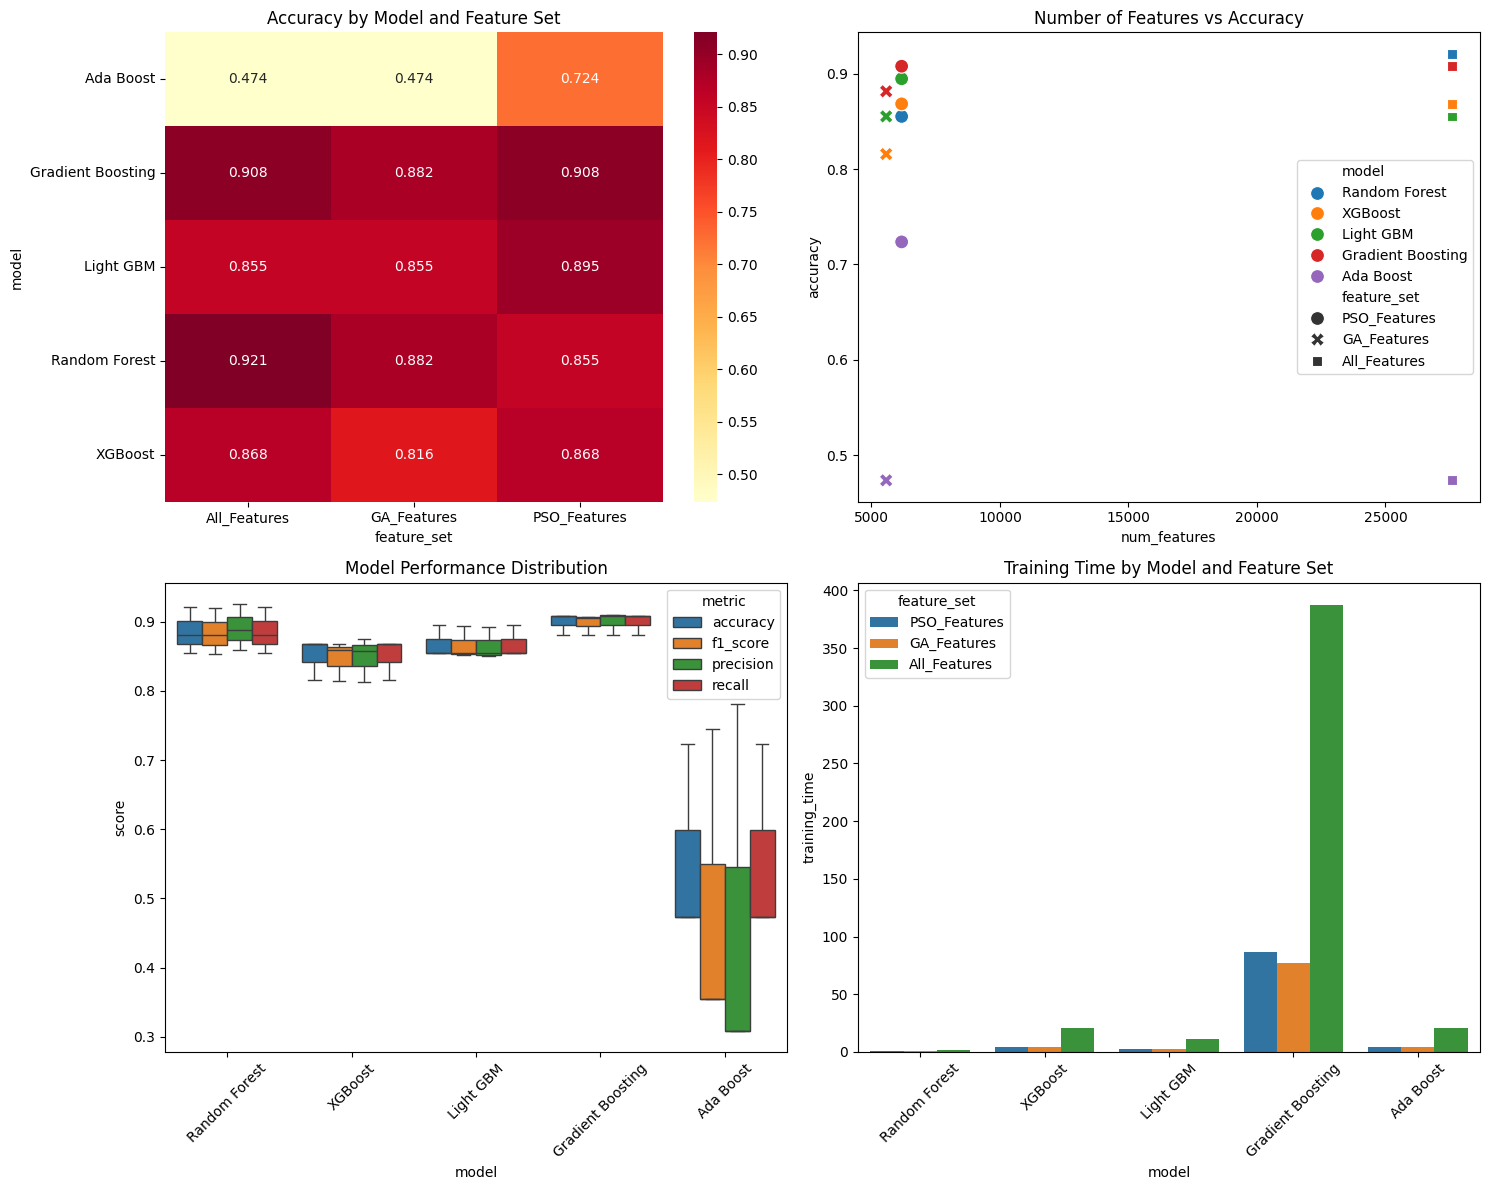


📋 DETAILED RESULTS:
     feature_set              model  num_features  accuracy   Kappa  f1_macro  \
0   PSO_Features      Random Forest          6178    0.8553  0.8008    0.7964   
1   PSO_Features            XGBoost          6178    0.8684  0.8190    0.8230   
2   PSO_Features          Light GBM          6178    0.8947  0.8548    0.8508   
3   PSO_Features  Gradient Boosting          6178    0.9079  0.8730    0.8709   
4   PSO_Features          Ada Boost          6178    0.7237  0.6246    0.6585   
5    GA_Features      Random Forest          5577    0.8816  0.8370    0.8342   
6    GA_Features            XGBoost          5577    0.8158  0.7458    0.7469   
7    GA_Features          Light GBM          5577    0.8553  0.8005    0.7917   
8    GA_Features  Gradient Boosting          5577    0.8816  0.8368    0.8296   
9    GA_Features          Ada Boost          5577    0.4737  0.3185    0.3401   
10  All_Features      Random Forest         27577    0.9211  0.8912    0.8905   
11  All

In [19]:
results, best_per_set, overall_best = run_comprehensive_feature_testing(
    X_train_nfs, X_test_nfs, y_train_all, y_test_nfs, 
    X_selected_pso.columns.to_list(), 
    X_selected_ga.columns.to_list()
)

# Get best feature set for each model
best_per_model = get_best_feature_set_per_model(results)
print("\n🏅 BEST FEATURE SET PER MODEL:")
print(best_per_model)

# Save results for future reference
results.to_csv('feature_selection_comparison_results.csv', index=False)


VALIDATION SET:


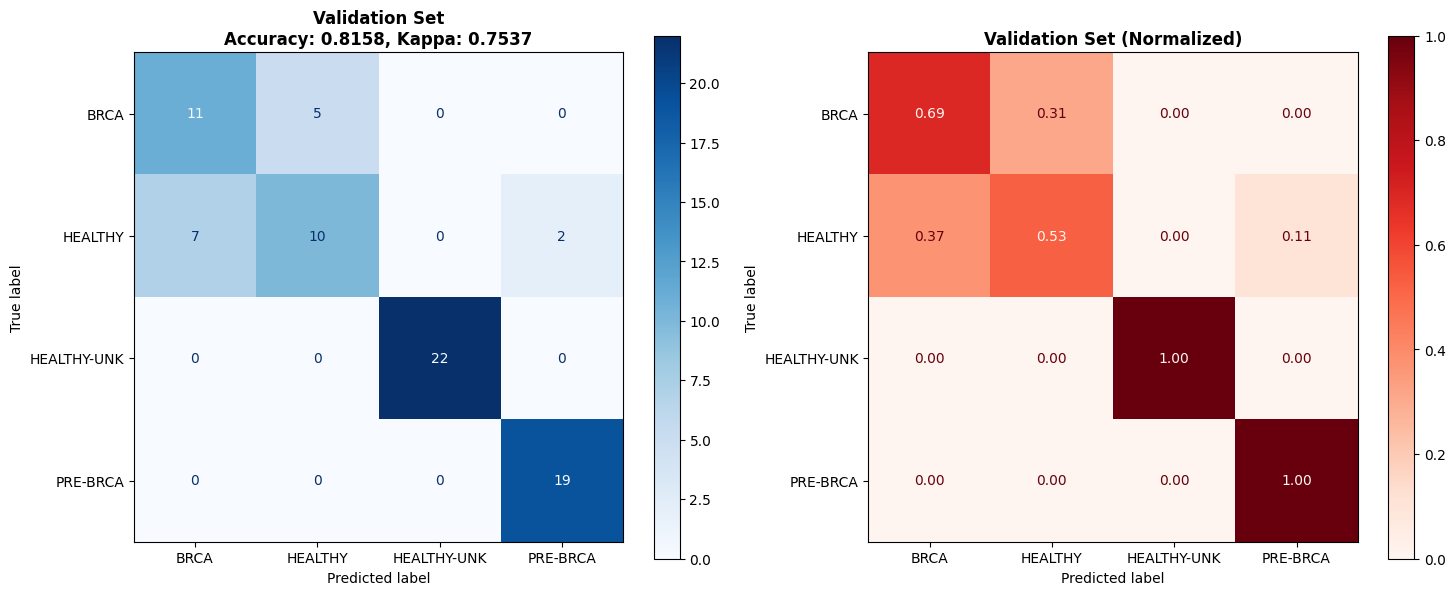


📊 Validation Set - Detailed Metrics:
   Accuracy: 0.8158
   Cohen's Kappa: 0.7537
   Total Samples: 76

TEST SET:


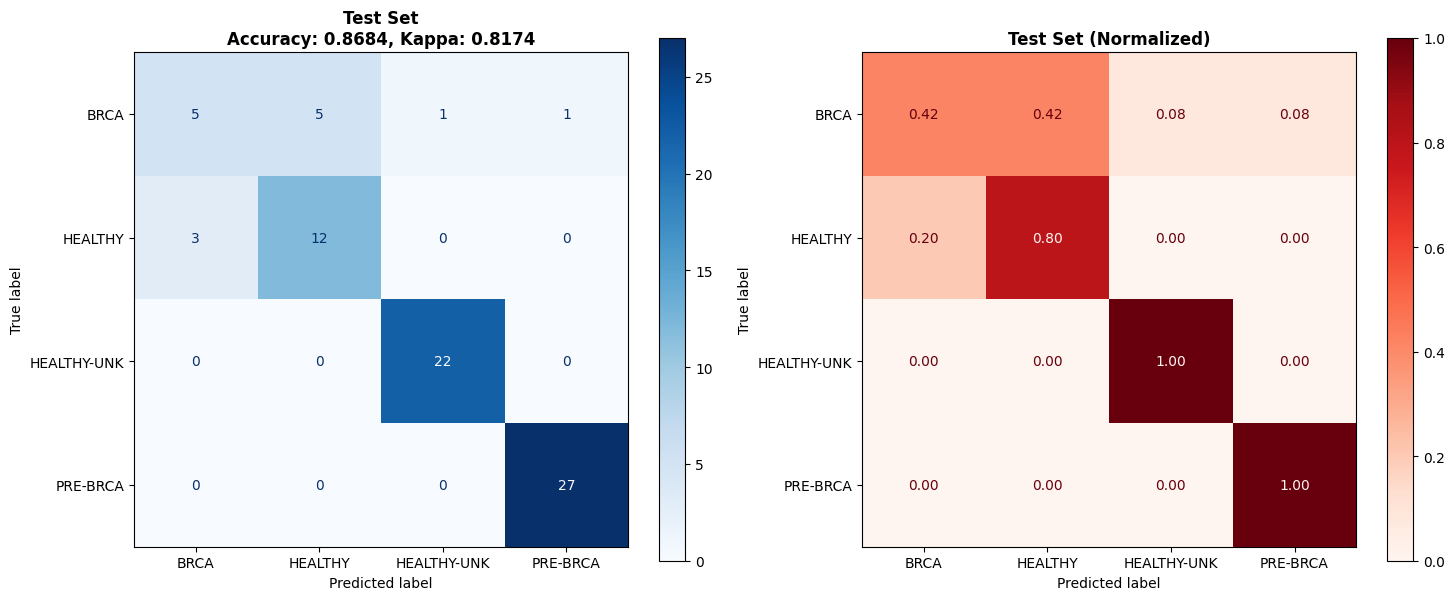


📊 Test Set - Detailed Metrics:
   Accuracy: 0.8684
   Cohen's Kappa: 0.8174
   Total Samples: 76


In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def enhanced_confusion_matrix(model, X, y_true, label_encoder, title="Confusion Matrix"):
    """
    Enhanced confusion matrix with additional metrics
    """
    y_pred = model.predict(X)
    cm = confusion_matrix(y_true, y_pred)
    class_names = label_encoder.classes_
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax1, values_format='d')
    ax1.set_title(f'{title}\nAccuracy: {accuracy:.4f}, Kappa: {kappa:.4f}', 
                  fontsize=12, fontweight='bold')
    
    # Plot 2: Normalized Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    disp_norm.plot(cmap='Reds', ax=ax2, values_format='.2f')
    ax2.set_title(f'{title} (Normalized)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print(f"\n📊 {title} - Detailed Metrics:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Cohen's Kappa: {kappa:.4f}")
    print(f"   Total Samples: {len(y_true)}")
    
    return cm, y_pred, accuracy, kappa

# Usage:
print("VALIDATION SET:")
cm_val, y_pred_val, acc_val, kappa_val = enhanced_confusion_matrix(
    selector, X_val_nfs, y_val_nfs, label_encoder, "Validation Set"
)

print("\nTEST SET:")
cm_test, y_pred_test, acc_test, kappa_test = enhanced_confusion_matrix(
    selector, X_test_nfs, y_test_nfs, label_encoder, "Test Set"
)

In [29]:
import numpy as np
from typing import Dict, Any, Optional, Union
from datetime import datetime

class BRCARiskReporter:
    """
    A class to generate comprehensive risk reports for breast cancer prediction.
    """
    
    def __init__(self):
        self.class_definitions = {
            'BRCA': {
                'description': 'Cancer detected',
                'risk_level': 'CRITICAL',
                'recommendation': 'Immediate medical consultation required'
            },
            'PRE-BRCA': {
                'description': 'High risk of developing cancer',
                'risk_level': 'HIGH',
                'recommendation': 'Regular monitoring and preventive consultation advised'
            },
            'HEALTHY': {
                'description': 'No signs of cancer detected',
                'risk_level': 'LOW',
                'recommendation': 'Continue regular screening as per guidelines'
            },
            'HEALTHY-UNK': {
                'description': 'Healthy but with uncertain markers',
                'risk_level': 'MODERATE',
                'recommendation': 'Follow-up testing recommended for clarification'
            }
        }
    
    def generate_report(self, model, instance: np.ndarray, 
                       class_names: Optional[list] = None,
                       patient_id: Optional[str] = None) -> Dict[str, Any]:
        """
        Generate a comprehensive prediction report for a single instance.
        
        Parameters:
        -----------
        model : trained classifier
            The trained model with predict() and predict_proba() methods
        instance : np.ndarray
            Single instance data (should be 2D array, e.g., [[features...]])
        class_names : list, optional
            List of class names in the order model returns them.
            Default: ['BRCA', 'HEALTHY', 'HEALTHY-UNK', 'PRE-BRCA']
        patient_id : str, optional
            Patient identifier for the report
            
        Returns:
        --------
        dict : Comprehensive report with prediction details
        """
        
        # Ensure instance is 2D
        if instance.ndim == 1:
            instance = instance.reshape(1, -1)
        
        # Set default class names if not provided
        if class_names is None:
            class_names = ['BRCA', 'HEALTHY', 'HEALTHY-UNK', 'PRE-BRCA']
        
        # Get prediction and probabilities
        prediction_idx = model.predict(instance)[0]
        probabilities = model.predict_proba(instance)[0]
        
        # Convert prediction index to class name
        if isinstance(prediction_idx, (int, np.integer)):
            predicted_class = class_names[prediction_idx]
        else:
            predicted_class = str(prediction_idx)
        
        # Create probability dictionary
        prob_dict = {class_names[i]: float(probabilities[i]) 
                     for i in range(len(class_names))}
        
        # Get class info
        class_info = self.class_definitions.get(predicted_class, {
            'description': 'Unknown classification',
            'risk_level': 'UNKNOWN',
            'recommendation': 'Consult with healthcare provider'
        })
        
        # Calculate cancer risk score (BRCA + PRE-BRCA probabilities)
        cancer_risk_score = prob_dict.get('BRCA', 0) + prob_dict.get('PRE-BRCA', 0)
        
        # Build the report
        report = {
            'patient_id': patient_id or 'N/A',
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'prediction': {
                'class': predicted_class,
                'description': class_info['description'],
                'risk_level': class_info['risk_level']
            },
            'probabilities': prob_dict,
            'risk_assessment': {
                'cancer_risk_score': round(cancer_risk_score * 100, 2),
                'current_cancer_probability': round(prob_dict.get('BRCA', 0) * 100, 2),
                'future_cancer_probability': round(prob_dict.get('PRE-BRCA', 0) * 100, 2),
                'healthy_probability': round(prob_dict.get('HEALTHY', 0) * 100, 2)
            },
            'recommendation': class_info['recommendation'],
            'confidence': round(max(probabilities) * 100, 2)
        }
        
        return report
    
    def print_report(self, report: Dict[str, Any]) -> None:
        """
        Print a formatted version of the report.
        
        Parameters:
        -----------
        report : dict
            Report dictionary from generate_report()
        """
        print("=" * 70)
        print("BREAST CANCER RISK ASSESSMENT REPORT")
        print("=" * 70)
        print(f"Patient ID: {report['patient_id']}")
        print(f"Timestamp: {report['timestamp']}")
        print()
        
        print("PREDICTION:")
        print(f"  Classification: {report['prediction']['class']}")
        print(f"  Description: {report['prediction']['description']}")
        print(f"  Risk Level: {report['prediction']['risk_level']}")
        print(f"  Confidence: {report['confidence']}%")
        print()
        
        print("DETAILED PROBABILITIES:")
        for class_name, prob in report['probabilities'].items():
            print(f"  {class_name:15s}: {prob*100:6.2f}%")
        print()
        
        print("RISK ASSESSMENT:")
        print(f"  Overall Cancer Risk Score: {report['risk_assessment']['cancer_risk_score']}%")
        print(f"  Current Cancer Probability: {report['risk_assessment']['current_cancer_probability']}%")
        print(f"  Future Cancer Risk: {report['risk_assessment']['future_cancer_probability']}%")
        print(f"  Healthy Status: {report['risk_assessment']['healthy_probability']}%")
        print()
        
        print("RECOMMENDATION:")
        print(f"  {report['recommendation']}")
        print("=" * 70)
    
    def get_risk_interpretation(self, report: Dict[str, Any]) -> str:
        """
        Get a human-readable interpretation of the risk assessment.
        
        Parameters:
        -----------
        report : dict
            Report dictionary from generate_report()
            
        Returns:
        --------
        str : Human-readable interpretation
        """
        pred_class = report['prediction']['class']
        cancer_risk = report['risk_assessment']['cancer_risk_score']
        
        if pred_class == 'BRCA':
            return (f"⚠️ CRITICAL: The model indicates signs of breast cancer with "
                   f"{report['confidence']}% confidence. Immediate medical attention is required.")
        
        elif pred_class == 'PRE-BRCA':
            return (f"⚠️ HIGH RISK: The model suggests a {cancer_risk}% chance of developing "
                   f"breast cancer in the future. Preventive measures and regular monitoring "
                   f"are strongly recommended.")
        
        elif pred_class == 'HEALTHY':
            return (f"✓ LOW RISK: No signs of breast cancer detected. Cancer risk score is "
                   f"{cancer_risk}%. Continue with regular screening schedules.")
        
        elif pred_class == 'HEALTHY-UNK':
            return (f"⚠️ MODERATE: While generally healthy, some uncertain markers were detected. "
                   f"Cancer risk score is {cancer_risk}%. Follow-up testing is recommended "
                   f"for clarification.")
        
        return "Unable to interpret results. Please consult with a healthcare provider."

    
# Create reporter instance
reporter = BRCARiskReporter()
report = reporter.generate_report(
        model=selector,
        instance=prebrca_cases.iloc[1, :-1].to_numpy(),
        class_names=['BRCA', 'HEALTHY', 'HEALTHY-UNK', 'PRE-BRCA'],
        patient_id='P12345'
    )   
reporter.print_report(report)
interpretation = reporter.get_risk_interpretation(report)
print("\nINTERPRETATION:")
print(interpretation)

BREAST CANCER RISK ASSESSMENT REPORT
Patient ID: P12345
Timestamp: 2025-10-28 20:44:30

PREDICTION:
  Classification: PRE-BRCA
  Description: High risk of developing cancer
  Risk Level: HIGH
  Confidence: 99.58999633789062%

DETAILED PROBABILITIES:
  BRCA           :   0.08%
  HEALTHY        :   0.08%
  HEALTHY-UNK    :   0.26%
  PRE-BRCA       :  99.59%

RISK ASSESSMENT:
  Overall Cancer Risk Score: 99.67%
  Current Cancer Probability: 0.08%
  Future Cancer Risk: 99.59%
  Healthy Status: 0.08%

RECOMMENDATION:
  Regular monitoring and preventive consultation advised

INTERPRETATION:
⚠️ HIGH RISK: The model suggests a 99.67% chance of developing breast cancer in the future. Preventive measures and regular monitoring are strongly recommended.
